## Introduction

This is the third in a series of lessons related to astronomy data.

As a running example, we are replicating parts of the analysis in a recent paper, "[Off the beaten path: Gaia reveals GD-1 stars outside of the main stream](https://arxiv.org/abs/1805.00425)" by Adrian M. Price-Whelan and Ana Bonaca.

In the first lesson, we wrote ADQL queries and used them to select and download data from the Gaia server.

In the second lesson, we wrote a query to select stars from the region of the sky where we expect GD-1 to be, and saved the results in a FITS file.

Now we'll read that data back and implement the next step in the analysis, identifying stars with the proper motion we expect for GD-1.

## Lesson 3

Here are the steps in this lesson:

1. We'll read back the results from the previous lesson, which we saved in a FITS file.

2. Then we'll transform the coordinates and proper motion data from ICRS back to the coordinate frame of GD-1.

3. We'll put those results into a Pandas `DataFrame`, which we'll use to select stars near the centerline of GD-1.

4. Plotting the proper motion of those stars, we'll identify a region of proper motion for stars that are likely to be in GD-1.

5. Finally, we'll select and plot the stars whose proper motion is in that region.

After completing this lesson, you should be able to

* Select rows and columns from an Astropy `Table`.

* Use Matplotlib to make a scatter plot.

* Use Gala to transform coordinates.

* Make a Pandas `DataFrame` and use a Boolean `Series` to select rows.

* Save a `DataFrame` in an HDF5 file.


## Installing libraries

If you are running this notebook on Colab, you can run the following cell to install Astroquery and a the other libraries we'll use.

If you are running this notebook on your own computer, you might have to install these libraries yourself.  

If you are using this notebook as part of a Carpentries workshop, you should have received setup instructions.

TODO: Add a link to the instructions.


In [1]:
# If we're running on Colab, install libraries

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install astroquery astro-gala pyia python-wget

## Reload the data

In the previous lesson, we ran a query on the Gaia server and downloaded data for roughly 100,000 stars.  We saved the data in a FITS file so that now, picking up where we left off, we can read the data from a local file rather than running the query again.

If you ran the previous lesson successfully, you should already have a file called `gd1_results.fits` that contains the data we downloaded.

If not, you can run the following cell, which downloads the data from our repository.

In [2]:
import os
from wget import download

filename = 'gd1_results.fits'
path = 'https://github.com/AllenDowney/AstronomicalData/raw/main/data/'

if not os.path.exists(filename):
    print(download(path+filename))

Now here's how we can read the data from the file back into an Astropy `Table`:

In [3]:
from astropy.table import Table

results = Table.read(filename)

The result is an Astropy `Table`.

We can use `info` to refresh our memory of the contents.

In [4]:
results.info

<Table length=140340>
      name       dtype    unit                              description                            
--------------- ------- -------- ------------------------------------------------------------------
      source_id   int64          Unique source identifier (unique within a particular Data Release)
             ra float64      deg                                                    Right ascension
            dec float64      deg                                                        Declination
           pmra float64 mas / yr                         Proper motion in right ascension direction
          pmdec float64 mas / yr                             Proper motion in declination direction
       parallax float64      mas                                                           Parallax
 parallax_error float64      mas                                         Standard error of parallax
radial_velocity float64   km / s                                              

## Selecting rows and columns

In this section we'll see operations for selecting columns and rows from an Astropy `Table`.  You can find more information about these operations in the [Astropy documentation](https://docs.astropy.org/en/stable/table/access_table.html).

We can get the names of the columns like this:

In [5]:
results.colnames

['source_id',
 'ra',
 'dec',
 'pmra',
 'pmdec',
 'parallax',
 'parallax_error',
 'radial_velocity']

And select an individual column like this:

In [6]:
results['ra']

142.48301935991023
142.25452941346344
142.64528557468074
142.57739430926034
142.58913564478618
141.81762228999614
143.18339801317677
142.9347319464589
142.26769745823267
142.89551292869012
142.2780935768316


The result is a `Column` object that contains the data, and also the data type, units, and name of the column.

In [7]:
type(results['ra'])

astropy.table.column.Column

The rows in the `Table` are numbered from 0 to `n-1`, where `n` is the number of rows.  We can select the first row like this:

In [8]:
results[0]

source_id,ra,dec,pmra,pmdec,parallax,parallax_error,radial_velocity
,deg,deg,mas / yr,mas / yr,mas,mas,km / s
int64,float64,float64,float64,float64,float64,float64,float64
637987125186749568,142.48301935991023,21.75771616932985,-2.5168384683875766,2.941813096629439,-0.2573448962333354,0.823720794509811,1e+20


As you might have guessed, the result is a `Row` object.

In [9]:
type(results[0])

astropy.table.row.Row

Notice that the bracket operator selects both columns and rows.  You might wonder how it knows which to select.

If the expression in brackets is a string, it selects a column; if the expression is an integer, it selects a row.

If you apply the bracket operator twice, you can select a column and then an element from the column.

In [10]:
results['ra'][0]

142.48301935991023

Or you can select a row and then an element from the row.

In [11]:
results[0]['ra']

142.48301935991023

You get the same result either way.

## Scatter plot

To see what the results look like, we'll use a scatter plot.  The library we'll use is [Matplotlib](https://matplotlib.org/), which is the most widely-used plotting library for Python.

The Matplotlib interface is based on MATLAB (hence the name), so if you know MATLAB, some of it will be familiar.

We'll import like this.

In [12]:
import matplotlib.pyplot as plt

Pyplot part of the Matplotlib library.  It is conventional to import it using the shortened name `plt`.

Pyplot provides two functions that can make scatterplots, [plt.scatter](https://matplotlib.org/3.3.0/api/_as_gen/matplotlib.pyplot.scatter.html) and [plt.plot](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html).

* `scatter` is more versatile; for example, you can make every point in a scatter plot a different color.

* `plot` is more limited, but for simple cases, it can be substantially faster.  

Jake Vanderplas explains these differences in [The Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/04.02-simple-scatter-plots.html)

Since we are plotting more than 100,000 points and they are all the same size and color, we'll use `plot`.

Here's a scatter plot with right ascension on the x-axis and declination on the y-axis, both ICRS coordinates in degrees.

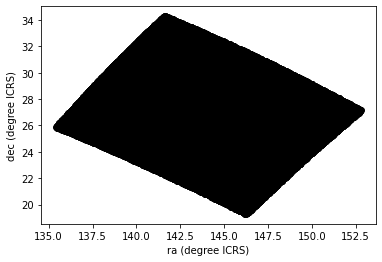

In [13]:
x = results['ra']
y = results['dec']
plt.plot(x, y, 'ko')

plt.xlabel('ra (degree ICRS)')
plt.ylabel('dec (degree ICRS)');

The arguments to `plt.plot` are `x`, `y`, and a string that specifies the style.  In this case, the letters `ko` indicate that we want a black, round marker (`k` is for black because `b` is for blue).

The functions `xlabel` and `ylabel` put labels on the axes.

This scatter plot has a problem.  It is "[overplotted](https://python-graph-gallery.com/134-how-to-avoid-overplotting-with-python/)", which means that there are so many overlapping points, we can't distinguish between high and low density areas.

To fix this, we can provide optional arguments to control the size and transparency of the points.

**Exercise:** In the call to `plt.plot`, add the keyword argument `markersize=0.1` to make the markers smaller.

Then add the argument `alpha=0.1` to make the markers nearly transparent.

Adjust these arguments until you think the figure shows the data most clearly.

Note: Once you have made these changes, you might notice that the figure shows stripes with lower density of stars.  These stripes are caused by the way Gaia scans the sky, which [you can read about here](https://www.cosmos.esa.int/web/gaia/scanning-law).  The dataset we are using, [Gaia Data Release 2](https://www.cosmos.esa.int/web/gaia/dr2), covers 22 months of observations; during this time, some parts of the sky were scanned more than others.

## Transform back

Remember that we selected data from a rectangle of coordinates in the `GD1Koposov10` frame, then transformed them to ICRS when we constructed the query.
The coordinates in `results` are in ICRS.

To plot them, we will transform them back to the `GD1Koposov10` frame; that way, the axes of the figure are aligned with the GD-1, which will make it easy to select stars near the centerline of the stream.

To do that, we'll put the results into a `GaiaData` object, provided by the [pyia library](https://pyia.readthedocs.io/en/latest/api/pyia.GaiaData.html).

In [14]:
from pyia import GaiaData

gaia_data = GaiaData(results)
type(gaia_data)

pyia.data.GaiaData

Now we can extract sky coordinates from the `GaiaData` object, like this:

In [73]:
import astropy.units as u

skycoord = gaia_data.get_skycoord(
                distance=8*u.kpc, 
                radial_velocity=0*u.km/u.s)

We provide `distance` and `radial_velocity` to prepare the data for reflex correction, which we explain below.

In [75]:
type(skycoord)

astropy.coordinates.sky_coordinate.SkyCoord

The result is an Astropy `SkyCoord` object ([documentation here](https://docs.astropy.org/en/stable/api/astropy.coordinates.SkyCoord.html#astropy.coordinates.SkyCoord)), which provides `transform_to`, so we can transform the coordinates to other frames.

In [76]:
import gala.coordinates as gc

transformed = skycoord.transform_to(gc.GD1Koposov10)
type(transformed)

astropy.coordinates.sky_coordinate.SkyCoord

The result is another `SkyCoord` object, now in the `GD1Koposov10` frame.

The next step is to correct the proper motion measurements from Gaia for reflex due to the motion of our solar system around the Galactic center.

When we created `skycoord`, we provided `distance` and `radial_velocity` as arguments, which means we ignore the measurements provided by Gaia and replace them with these fixed values.

That might seem like a strange thing to do, but here's the motivation:

* Because the stars in GD-1 are so far away, the distance estimates we get from Gaia, which are based on parallax, are not very precise.  So we replace them with our current best estimate of the mean distance to GD-1, about 8 kpc.  [Koposov, Rix, and Hogg, 2010](https://ui.adsabs.harvard.edu/abs/2010ApJ...712..260K/abstract)

* For the other stars in the table, this distance estimate will be inaccurate, so reflect correction will not be correct.  But that should have only a small effect on our ability to identify stars with the proper motion we expect for GD-1.

* The measurement of radial velocity has no effect on the correction for proper motion; the value we provide is arbitrary, but we have to provide a value to avoid errors in the reflex correction calculation.

We are grateful to Adrian Price-Whelen for his help explaining this step in the analysis.

With this preparation, we can use `reflex_correct` from Gala ([documentation here](https://gala-astro.readthedocs.io/en/latest/api/gala.coordinates.reflex_correct.html)) to correct for solar reflex motion.

In [77]:
gd1_coord = gc.reflex_correct(transformed)

type(gd1_coord)

astropy.coordinates.sky_coordinate.SkyCoord

The result is a `SkyCoord` object that contains 

* The transformed coordinates as attributes named `phi1` and `phi2`, which represent right ascension and declination in the `GD1Koposov10` frame.

* The transformed and corrected proper motions as `pm_phi1_cosphi2` and `pm_phi2`.

We can select the coordinates like this:

In [78]:
phi1 = gd1_coord.phi1
phi2 = gd1_coord.phi2

And plot them like this:

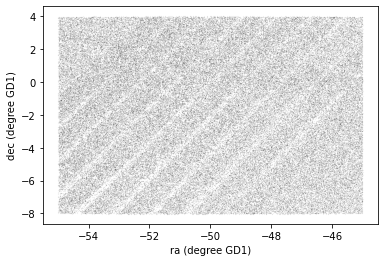

In [79]:
plt.plot(phi1, phi2, 'ko', markersize=0.1, alpha=0.2)

plt.xlabel('ra (degree GD1)')
plt.ylabel('dec (degree GD1)');

Remember that we started with a rectangle in GD-1 coordinates.  When transformed to ICRS, it's a non-rectangular polygon.  Now that we have transformed back to GD-1 coordinates, it's a rectangle again.

## Pandas DataFrame

At this point we have three objects containing different subsets of the data.

In [80]:
type(results)

astropy.table.table.Table

In [81]:
type(gaia_data)

pyia.data.GaiaData

In [82]:
type(gd1_coord)

astropy.coordinates.sky_coordinate.SkyCoord

On one hand, this makes sense, since each object provides different capabilities.  But working with three different object types can be awkward.

It will be more convenient to choose one object and get all of the data into it.  We'll use a Pandas DataFrame, for two reasons:

1. It provides capabilities that are pretty much a superset of the other data structures, so it's the all-in-one solution.

2. Pandas is a general-purpose tool that is useful in many domains, especially data science.  If you are going to develop expertise in one tool, Pandas is a good choice.

However, compared to an Astropy `Table`, Pandas has one big drawback: it does not keep the metadata associated with the table, including the units for the columns.

It's easy to convert a `Table` to a Pandas `DataFrame`.

In [83]:
import pandas as pd

df = results.to_pandas()
df.shape

(140340, 8)

`DataFrame` provides `shape`, which shows the number of rows and columns.

It also provides `head`, which displays the first few rows.  It is useful for spot-checking large results as you go along.

In [84]:
df.head()

,source_id,ra,dec,pmra,pmdec,parallax,parallax_error,radial_velocity
0,637987125186749568,142.483019,21.757716,-2.516838,2.941813,-0.257345,0.823721,1.000000e+20
1,638285195917112960,142.254529,22.476168,2.662702,-12.165984,0.422728,0.297472,1.000000e+20
2,638073505568978688,142.645286,22.166932,18.306747,-7.950660,0.103640,0.544584,1.000000e+20
3,638086386175786752,142.577394,22.227920,0.987786,-2.584105,-0.857327,1.059607,1.000000e+20
4,638049655615392384,142.589136,22.110783,0.244439,-4.941079,0.099625,0.486224,1.000000e+20


Python detail: `shape` is an attribute, so we can display it's value without calling it as a function; `head` is a function, so we need the parentheses.

Now we can extract the columns we want from `gd1_coord` and add them as columns in the `DataFrame`.  `phi1` and `phi2` contain the transformed coordinates.

In [85]:
df['phi1'] = gd1_coord.phi1
df['phi2'] = gd1_coord.phi2
df.shape

(140340, 10)

`pm_phi1_cosphi2` and `pm_phi2` contain the components of proper motion in the transformed frame.

In [86]:
df['pm_phi1'] = gd1_coord.pm_phi1_cosphi2
df['pm_phi2'] = gd1_coord.pm_phi2
df.shape

(140340, 12)

**Detail:** If you notice that `SkyCoord` has an attribute called `proper_motion`, you might wonder why we are not using it.

We could have: `proper_motion` contains the same data as `pm_phi1_cosphi2` and `pm_phi2`, but in a different format.

## Plot proper motion

Now we are ready to replicate one of the panels in Figure 1 of the Price-Whelan and Bonaca paper, the one that shows the components of proper motion as a scatter plot:

<img width="300" src="https://github.com/datacarpentry/astronomy-python/raw/gh-pages/fig/gd1-1.png">

In this figure, the shaded area is a high-density region of stars with the proper motion we expect for stars in GD-1.  

* Due to the nature of tidal streams, we expect the proper motion for most stars to be along the axis of the stream; that is, we expect motion in the direction of `phi2` to be near 0.

* In the direction of `phi1`, we don't have a prior expectation for proper motion, except that it should form a cluster at a non-zero value. 

To locate this cluster, we'll select stars near the centerline of GD-1 and plot their proper motion.

## Selecting the centerline

As we can see in the following figure, many stars in GD-1 are less than 1 degree of declination from the line `phi2=0`.

<img src="https://github.com/datacarpentry/astronomy-python/raw/gh-pages/fig/gd1-4.png">

If we select stars near this line, they are more likely to be in GD-1.

We'll start by selecting the `phi2` column from the `DataFrame`:

In [99]:
phi2 = df['phi2']
type(phi2)

pandas.core.series.Series

The result is a `Series`, which is the structure Pandas uses to represent columns.

We can use a comparison operator, `>`, to compare the values in a `Series` to a constant.

In [100]:
phi2_min = -1.0 * u.deg
phi2_max = 1.0 * u.deg

mask = (df['phi2'] > phi2_min)
type(mask)

pandas.core.series.Series

In [101]:
mask.dtype

dtype('bool')

The result is a `Series` of Boolean values, that is, `True` and `False`. 

In [102]:
mask.head()

0    False
1    False
2    False
3    False
4    False
Name: phi2, dtype: bool

A Boolean `Series` is sometimes called a "mask" because we can use it to mask out some of the rows in a `DataFrame` and select the rest, like this:

In [103]:
selected = df[mask]
type(selected)

pandas.core.frame.DataFrame

`selected` is a `DataFrame` that contains only the rows from `df` that correspond to `True` values in `mask`.

The previous mask selects all stars where `phi2` exceeds `phi2_min`; now we'll select stars where `phi2` falls between `phi2_min` and `phi2_max`.

In [104]:
phi_mask = ((df['phi2'] > phi2_min) & 
            (df['phi2'] < phi2_max))

The `&` operator computes "logical AND", which means the result is true where elements from both Boolean `Series` are true.

The sum of a Boolean `Series` is the number of `True` values, so we can use `sum` to see how many stars are in the selected region.

In [105]:
phi_mask.sum()

25084

And we can use `phi1_mask` to select stars near the centerline, which are more likely to be in GD-1.

In [106]:
centerline = df[phi_mask]
len(centerline)

25084

Here's a scatter plot of proper motion for the selected stars.

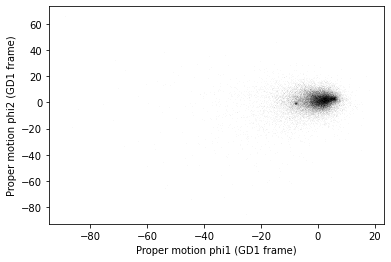

In [112]:
pm1 = centerline['pm_phi1']
pm2 = centerline['pm_phi2']

plt.plot(pm1, pm2, 'ko', markersize=0.1, alpha=0.1)
    
plt.xlabel('Proper motion phi1 (GD1 frame)')
plt.ylabel('Proper motion phi2 (GD1 frame)');

Looking at these results, we see a large cluster around (0, 0), and a smaller cluster near (0, -10).

We can use `xlim` and `ylim` to set the limits on the axes and zoom in on the region near (0, 0).

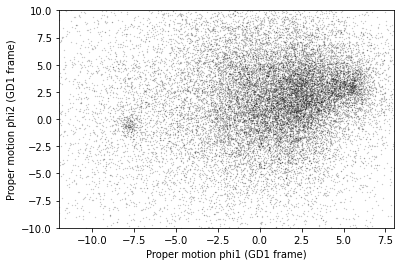

In [113]:
pm1 = centerline['pm_phi1']
pm2 = centerline['pm_phi2']

plt.plot(pm1, pm2, 'ko', markersize=0.3, alpha=0.3)
    
plt.xlabel('Proper motion phi1 (GD1 frame)')
plt.ylabel('Proper motion phi2 (GD1 frame)')

plt.xlim(-12, 8)
plt.ylim(-10, 10);

Now we can see the smaller cluster more clearly.

You might notice that our figure is less dense than the one in the paper.  That's because we started with a set of stars from a relatively small region.  The figure in the paper is based on a region about 10 times bigger.

In the next lesson we'll go back and select stars from a larger region.  But first we'll use the proper motion data to identify stars likely to be in GD-1.

## Filtering based on proper motion

The next step is to select stars in the "overdense" region of proper motion, which are candidates to be in GD-1.

In the original paper, Price-Whelan and Bonaca used a polygon to cover this region, as shown in this figure.

<img width="300" src="https://github.com/datacarpentry/astronomy-python/raw/gh-pages/fig/gd1-1.png">

We'll use a simple rectangle for now, but in a later lesson we'll see how to select a polygonal region as well.

Here are bounds on proper motion we chose by eye,

In [96]:
pm1_min = -8.9
pm1_max = -6.9
pm2_min = -2.2
pm2_max =  1.0

To draw these bounds, we'll make two lists containing the coordinates of the corners of the rectangle.

In [114]:
pm1_rect = [pm1_min, pm1_min, pm1_max, pm1_max, pm1_min] * u.mas/u.yr
pm2_rect = [pm2_min, pm2_max, pm2_max, pm2_min, pm2_min] * u.mas/u.yr

Here's what the plot looks like with the bounds we chose.

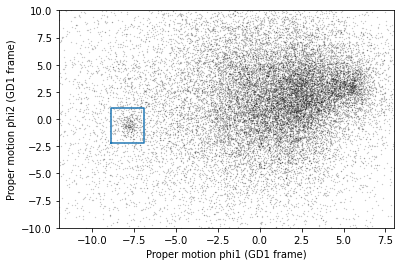

In [118]:
plt.plot(pm1, pm2, 'ko', markersize=0.3, alpha=0.3)
plt.plot(pm1_rect, pm2_rect, '-')
    
plt.xlabel('Proper motion phi1 (GD1 frame)')
plt.ylabel('Proper motion phi2 (GD1 frame)')

plt.xlim(-12, 8)
plt.ylim(-10, 10);

To select rows that fall within these bounds, we'll use the following function, which uses Pandas operators to make a mask that selects rows where `series` falls between `low` and `high`.

In [119]:
def between(series, low, high):
    """Make a Boolean Series.
    
    series: Pandas Series
    low: lower bound
    high: upper bound
    
    returns: Boolean Series
    """
    return (series > low) & (series < high)

The following mask select stars with proper motion in the region we chose.

In [120]:
pm_mask = (between(df['pm_phi1'], pm1_min, pm1_max) & 
           between(df['pm_phi2'], pm2_min, pm2_max))

Again, the sum of a Boolean series is the number of `True` values.

In [121]:
pm_mask.sum()

1049

Now we can use this mask to select rows from `df`.

In [122]:
selected = df[pm_mask]
len(selected)

1049

These are the stars we think are likely to be in GD-1.  Let's see what they look like, plotting their coordinates (not their proper motion).

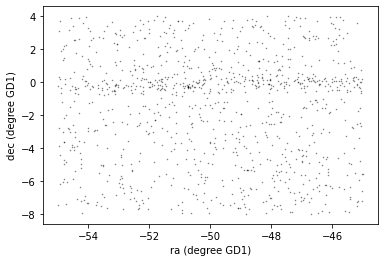

In [123]:
phi1 = selected['phi1']
phi2 = selected['phi2']

plt.plot(phi1, phi2, 'ko', markersize=0.5, alpha=0.5)

plt.xlabel('ra (degree GD1)')
plt.ylabel('dec (degree GD1)');

Now that's starting to look like a tidal stream!

## Saving the DataFrame

At this point we have run a successful query and cleaned up the results; this is a good time to save the data.

To save a Pandas `DataFrame`, one option is to convert it to an Astropy `Table`, like this:

In [124]:
selected_table = Table.from_pandas(selected)
type(selected_table)

astropy.table.table.Table

Then we could write the `Table` to a FITS file, as we did in the previous lesson.  

But Pandas provides functions to write DataFrames in other formats; to see what they are [find the functions here that begin with `to_`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html).

One of the best options is HDF5, which is Version 5 of [Hierarchical Data Format](https://en.wikipedia.org/wiki/Hierarchical_Data_Format).

HDF5 is a binary format, so files are small and fast to read and write (like FITS, but unlike XML).

An HDF5 file is similar to an SQL database in the sense that it can contain more than one table, although in HDF5 vocabulary, a table is called a Dataset.  ([Multi-extension FITS files](https://www.stsci.edu/itt/review/dhb_2011/Intro/intro_ch23.html) can also contain more than one table.)

And HDF5 stores the metadata associated with the table, including column names, row labels, and data types (like FITS).

Finally, HDF5 is a cross-language standard, so if you write an HDF5 file with Pandas, you can read it back with many other software tools (more than FITS).

Before we write the HDF5, let's delete the old one, if it exists.

In [125]:
!rm -f gd1_dataframe.hdf5

We can write a Pandas `DataFrame` to an HDF5 file like this:

In [126]:
filename = 'gd1_dataframe.hdf5'

df.to_hdf(filename, 'df')

Because an HDF5 file can contain more than one Dataset, we have to provide a name, or "key", that identifies the Dataset in the file.

We could use any string as the key, but in this example I use the variable name `df`.

**Exercise:** We're going to need `centerline` and `selected` later as well.  Write a line or two of code to add it as a second Dataset in the HDF5 file.

In [127]:
# Solution

centerline.to_hdf(filename, 'centerline')
selected.to_hdf(filename, 'selected')

**Detail:** Reading and writing HDF5 tables requires a library called `PyTables` that is not always installed with Pandas.  You can install it with pip like this:

```
pip install tables
```

If you install it using Conda, the name of the package is `pytables`.

```
conda install pytables
```

We can use `ls` to confirm that the file exists and check the size:

In [128]:
!ls -lh gd1_dataframe.hdf5

-rw-rw-r-- 1 downey downey 17M Oct 19 12:05 gd1_dataframe.hdf5


If you are using Windows, `ls` might not work; in that case, try:

```
!dir gd1_dataframe.hdf5
```

We can read the file back like this:

In [129]:
read_back_df = pd.read_hdf(filename, 'df')
read_back_df.shape

(140340, 12)

Pandas can write a variety of other formats, [which you can read about here](https://pandas.pydata.org/pandas-docs/stable/user_guide/io.html).

## Summary

In this lesson, we re-loaded the Gaia data we saved from a previous query.

We transformed the coordinates and proper motion from ICRS to a frame aligned with GD-1, and stored the results in a Pandas `DataFrame`.

Then we replicated the selection process from the Price-Whelan and Bonaca paper:

* We selected stars near the centerline of GD-1 and made a scatter plot of their proper motion.

* We identified a region of proper motion that contains stars likely to be in GD-1.

* We used a Boolean `Series` as a mask to select stars whose proper motion is in that region.

So far, we have used data from a relatively small region of the sky.  In the next lesson, we'll write a query that selects stars based on proper motion, which will allow us to explore a larger region.

## Best practices

* When you make a scatter plot, adjust the size of the markers and their transparency so the figure is not overplotted; otherwise it can misrepresent the data badly.

* For simple scatter plots in Matplotlib, `plot` is faster than `scatter`.

* An Astropy `Table` and a Pandas `DataFrame` are similar in many ways and they provide many of the same functions.  They have pros and cons, but for many projects, either one would be a reasonable choice.